Cropped image shape: (270, 250, 3)
Cropped mask shape: (270, 250)


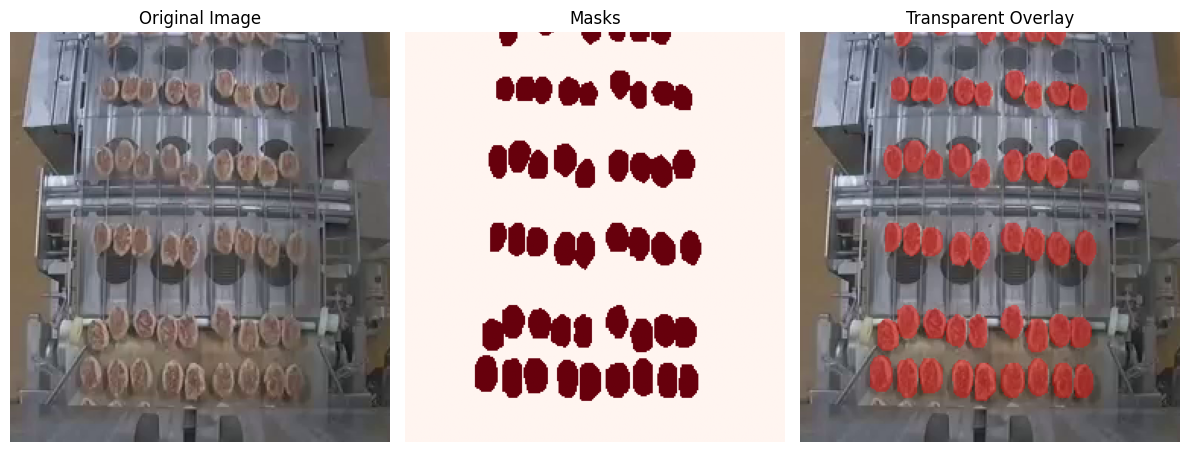

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from Helpers import show_masks_fixed, visualize_masks, load_and_crop_data


train_img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/images/train/frame_000000.PNG"
train_label_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/labels/train/frame_000000.txt"

# Define crop coordinates (y_start, y_end, x_start, x_end)
crop_coords = (30, 300, 200, 450)

# Load and crop both image and masks
train_img, train_masks_gt = load_and_crop_data(train_img_path, train_label_path, crop_coords)

# Verify dimensions
print(f"Cropped image shape: {train_img.shape}")
print(f"Cropped mask shape: {train_masks_gt[0].shape}")

# Visualize
visualize_masks(train_img, train_masks_gt)

Cropped image shape: (270, 250, 3)
Cropped mask shape: (270, 250)


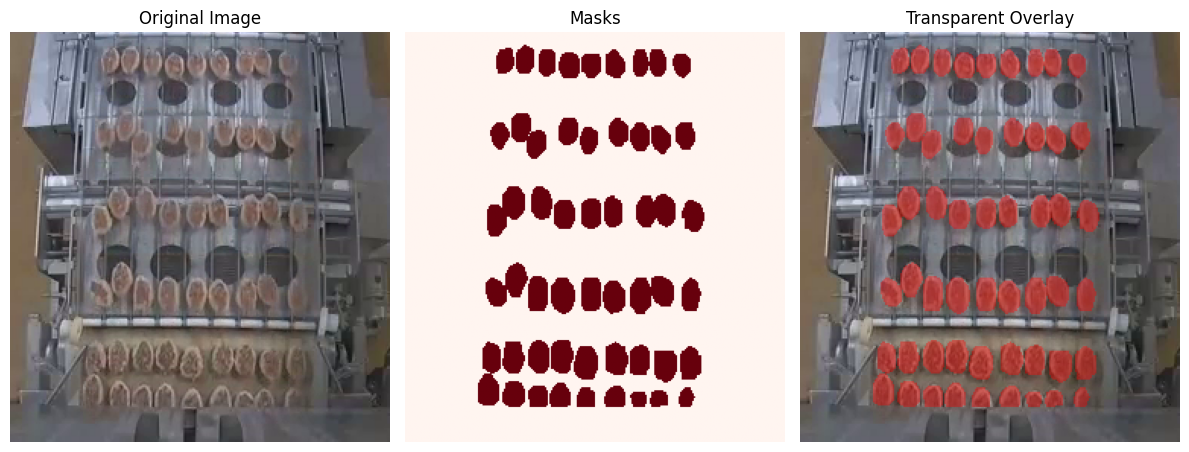

In [5]:
test_img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/images/train/frame_002388.PNG"
test_label_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/labels/train/frame_002388.txt"

test_img, test_masks_gt = load_and_crop_data(test_img_path, test_label_path, crop_coords)

print(f"Cropped image shape: {train_img.shape}")
print(f"Cropped mask shape: {train_masks_gt[0].shape}")

visualize_masks(test_img, test_masks_gt)

In [6]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.build_sam import build_sam2
from sam2.utils.misc import variant_to_config_mapping

model = build_sam2(
    variant_to_config_mapping["small"],
    "../models/sam2_hiera_small.pt",
)

mask_generator = SAM2AutomaticMaskGenerator(
    model,
    points_per_side=32,           # Increased from default 32
    pred_iou_thresh=0.7,          # Lowered from default 0.8
    stability_score_thresh=0.85,  # Lowered from default 0.95
    box_nms_thresh=0.6,           # Lowered from default 0.7
    )


In [7]:
train_masks = mask_generator.generate(train_img)

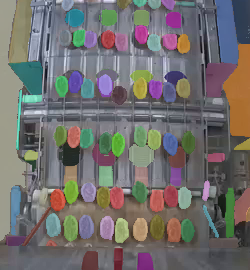

In [8]:
train_output_mask = show_masks_fixed(image = train_img, masks = train_masks, scores=None, only_best=False, autogenerated_mask=True)

train_output_mask

In [9]:
test_masks = mask_generator.generate(test_img)

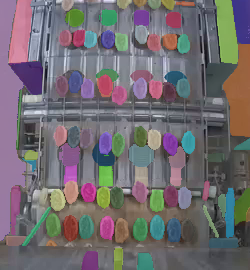

In [10]:
test_output_mask = show_masks_fixed(image = train_img, masks = train_masks, scores=None, only_best=False, autogenerated_mask=True)

test_output_mask

In [11]:
train_full_seg = []

for  mask in train_masks:
    bi_mask = mask["segmentation"]
    train_full_seg.append(bi_mask)

test_full_seg = []

for  mask in test_masks:
    bi_mask = mask["segmentation"]
    test_full_seg.append(bi_mask)


In [32]:
import numpy as np
from typing import List, Tuple, Union
import cv2

def process_segmentation_masks(
    gt_masks: List[np.ndarray], 
    full_masks: List[np.ndarray], 
    iou_threshold: float = 0.5
) -> Tuple[List[np.ndarray], List[int]]:
    """
    Process ground truth and full segmentation masks by:
    1. Identifying which full masks correspond to ground truth masks
    2. Removing those from the full segmentation masks
    3. Returning a combined list of all masks with corresponding labels
    
    Args:
        gt_masks: List of ground truth binary segmentation masks (np.ndarray)
        full_masks: List of all segmentation masks (np.ndarray)
        iou_threshold: IoU threshold to determine if a full mask matches a GT mask
        
    Returns:
        Tuple containing:
        - combined_masks: List of all masks (GT masks + remaining full masks)
        - labels: List of labels (1 for GT masks, 0 for remaining full masks)
    """
    # Check if inputs are valid
    if not gt_masks or not full_masks:
        raise ValueError("Both gt_masks and full_masks must be non-empty lists")
    
    # Ensure all masks have the same shape
    gt_shape = gt_masks[0].shape
    for mask in gt_masks + full_masks:
        if mask.shape != gt_shape:
            raise ValueError(f"All masks must have the same shape. Expected {gt_shape}, got {mask.shape}")
    
    # Calculate IoU between each GT mask and full mask
    mask_matches = []
    for full_idx, full_mask in enumerate(full_masks):
        matched = False
        for gt_mask in gt_masks:
            iou = calculate_iou(gt_mask, full_mask)
            if iou >= iou_threshold:
                matched = True
                break
        mask_matches.append(matched)
    
    # Create combined list of masks and labels
    combined_masks = []
    labels = []
    
    # Add all GT masks first (label 1)
    for gt_mask in gt_masks:
        combined_masks.append(gt_mask)
        labels.append(1)
    
    # Add remaining full masks (label 0)
    for idx, full_mask in enumerate(full_masks):
        if not mask_matches[idx]:
            combined_masks.append(full_mask)
            labels.append(0)
    
    return combined_masks, labels

def get_positive_negative_masks(combined_masks: List[np.ndarray], labels: List[int]) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    Separate the combined masks list into positive (GT) and negative (remaining) masks
    based on their corresponding labels.
    
    Args:
        combined_masks: List of all masks (GT + remaining)
        labels: List of labels (1 for GT masks, 0 for remaining masks)
        
    Returns:
        Tuple containing:
        - positive_masks: List of GT masks (label 1)
        - negative_masks: List of remaining masks (label 0)
    """
    positive_masks = []
    negative_masks = []
    
    for mask, label in zip(combined_masks, labels):
        if label == 1:
            positive_masks.append(mask)
        else:
            negative_masks.append(mask)
    
    return positive_masks, negative_masks

def calculate_iou(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Calculate the Intersection over Union (IoU) between two binary masks.
    
    Args:
        mask1: First binary mask (numpy array where positive values indicate mask)
        mask2: Second binary mask (numpy array where positive values indicate mask)
        
    Returns:
        IoU score (float between 0 and 1)
    """
    # Convert masks to binary (0 or 1)
    mask1_binary = (mask1 > 0).astype(np.uint8)
    mask2_binary = (mask2 > 0).astype(np.uint8)
    
    # Calculate intersection and union
    intersection = np.logical_and(mask1_binary, mask2_binary).sum()
    union = np.logical_or(mask1_binary, mask2_binary).sum()
    
    # Handle edge case
    if union == 0:
        return 0.0
    
    return intersection / union

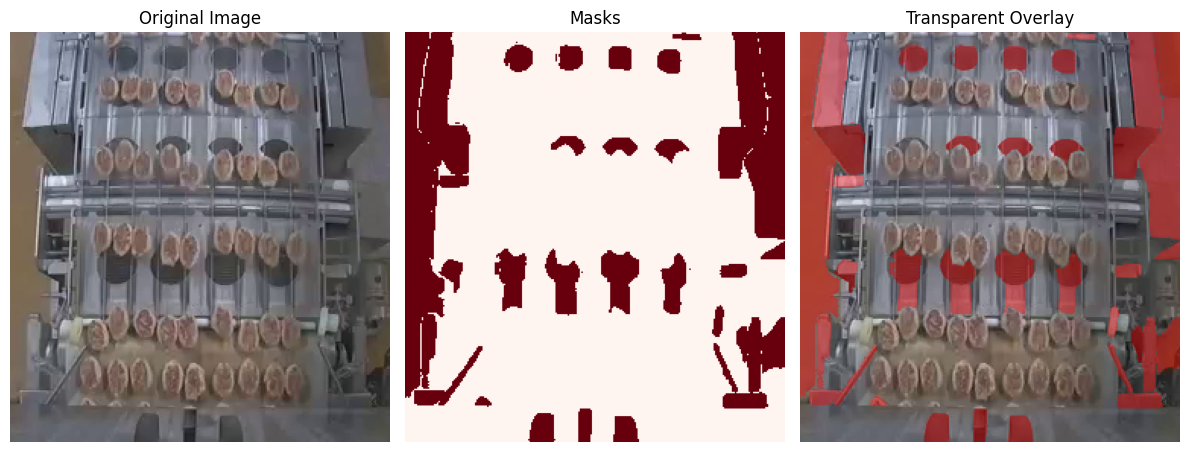

In [35]:
all_train_masks, train_labels = process_segmentation_masks(train_masks_gt, train_full_seg)

positive_masks, negative_masks = get_positive_negative_masks(all_train_masks, train_labels)

visualize_masks(train_img, negative_masks)


In [36]:
all_test_masks, test_labels = process_segmentation_masks(test_masks_gt, test_full_seg)

# TESTING

In [37]:
import sys
import os

# Get the absolute path to the repo root (parent of both src and notebook folders)
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the repo root to the Python path
sys.path.append(repo_root)

# Now you can import from src
from src.master.model import MultiLayerFeatureKNN

knn = MultiLayerFeatureKNN(layers=[2, 4, 6, 8], metric="cosine", pca_variance=0.99)

c:\Users\GustavToft\miniconda3\envs\masterenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\GustavToft\miniconda3\envs\masterenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
knn.fit(train_img, all_train_masks, train_labels)

Reduced feature dimension from 896 to 76 with 99.0% variance preserved


True

In [39]:
filtered_masks, filtered_probs = knn.predict(test_img, test_full_seg)

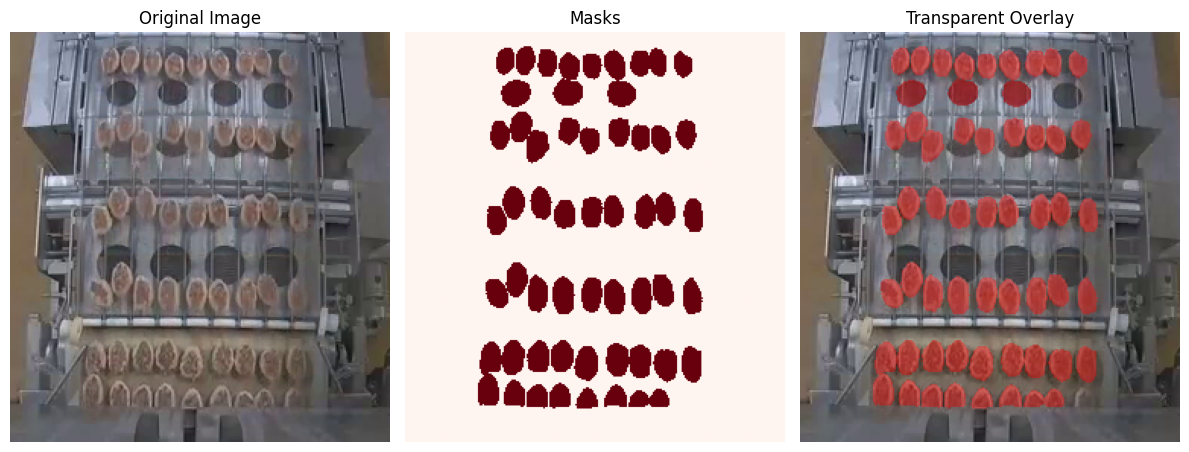

In [40]:
visualize_masks(test_img, filtered_masks)

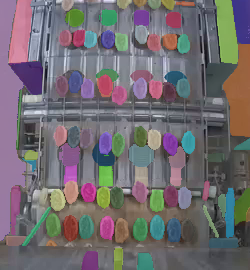

In [41]:
test_output_mask